In [189]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [306]:
n_dots = 5000
data_20x = pd.read_csv("/mnt/data/Imaging/202105-Deconwolf/data_210726/20x_dw_calc/001_allDots.csv").sort_values("Value", ascending=False).iloc[:n_dots, :].reset_index(drop=True)
data_60x = pd.read_csv("/mnt/data/Imaging/202105-Deconwolf/data_210726/60x_dw_calc/001_allDots.csv").sort_values("Value", ascending=False).iloc[:n_dots, :].reset_index(drop=True)

In [307]:
voxel_side_20x = 325
voxel_side_60x = 108.3

In [318]:
rad = 16

In [328]:
def get_nn_ids(A: np.ndarray, B: np.ndarray, rad: float, verbose: bool = True) -> pd.Series:
    paired_dist = cdist(A, B)
    if verbose:
        print(f"Smallest distance = {paired_dist.min():.3f}")
    
    dist_threshold = rad * 2
    paired_dist[paired_dist >= dist_threshold] = np.nan
    not_singletons_idx = np.where(np.isnan(paired_dist).sum(1) != paired_dist.shape[0])[0]
    if verbose:
        print(f"Dots with neighbor within {dist_threshold} => {not_singletons_idx.shape[0]} / {paired_dist.shape[0]}")
    
    return(pd.Series(data=np.nanargmin(paired_dist[not_singletons_idx, :], axis=1), index=not_singletons_idx, name="neighbour_id"))

In [341]:
id_match = get_nn_ids(data_20x.loc[:, ("x", "y")].values*3, data_60x.loc[:, ("x", "y")].values, rad)
id_match

Smallest distance = 0.031
Dots with neighbor within 32 => 4246 / 5000


0       3483
1       2761
2       1264
3       2599
4        741
        ... 
4991    4674
4992     665
4996    3568
4998    1677
4999    1672
Name: neighbour_id, Length: 4246, dtype: int64

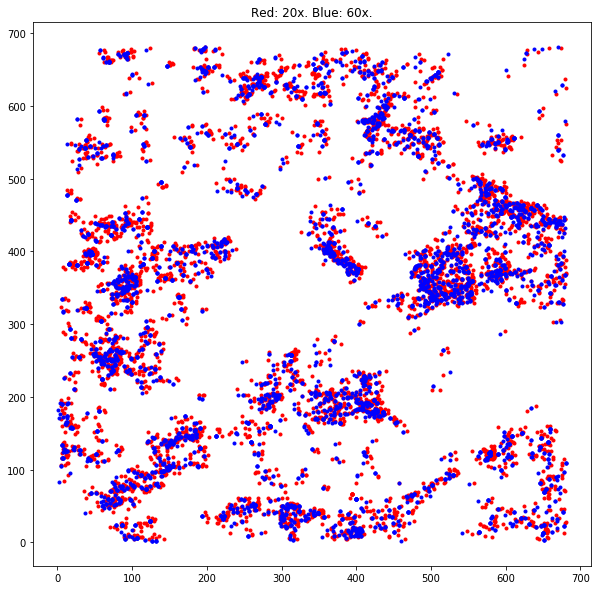

In [330]:
plt.figure(figsize=(10, 10))
plt.plot(data_20x.loc[id_match.index, "x"], data_20x.loc[id_match.index, "y"], "r.")
plt.plot(data_60x.loc[id_match.values, "x"]/3, data_60x.loc[id_match.values, "y"]/3, "b.")
plt.title("Red: 20x. Blue: 60x.")
plt.show()

In [331]:
def get_deltas(A: np.ndarray, B: np.ndarray, rad: float) -> np.ndarray:
    id_match = get_id_match(A, B, rad, False)
    return(A[id_match.index] - B[id_match.values])

In [332]:
deltas0 = get_deltas(data_20x.loc[:, ("x", "y")].values*3, data_60x.loc[:, ("x", "y")].values, rad)

In [333]:
def get_mean_shift(deltas: np.ndarray, rad: float) -> np.ndarray:
    v = np.array([0, 0])
    for r in np.linspace(rad*2, .1, 200):
        w = multivariate_normal.pdf(deltas, v, np.array([[2*rad, 0], [0, 2*rad]]))
        v = w.dot(deltas)/w.sum()
    return(v)

In [334]:
shift = get_mean_shift(deltas0, rad)

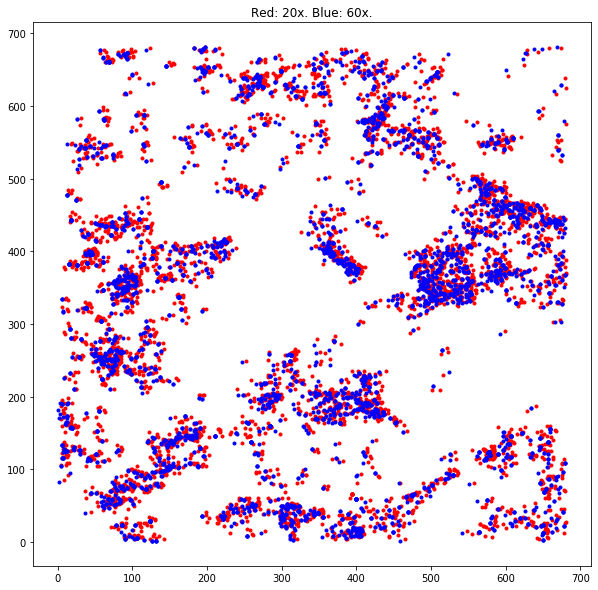

In [340]:
plt.figure(figsize=(10, 10))
plt.plot(data_20x.loc[id_match.index, "x"], data_20x.loc[id_match.index, "y"], "r.")
plt.plot(data_60x.loc[id_match.values, "x"]/3-delta[0], data_60x.loc[id_match.values, "y"]/3-delta[1], "b.")
plt.title("Red: 20x. Blue: 60x.")
plt.show()

In [335]:
deltas = get_deltas(data_20x.loc[:, ("x", "y")].values*3, data_60x.loc[:, ("x", "y")].values-shift, rad)

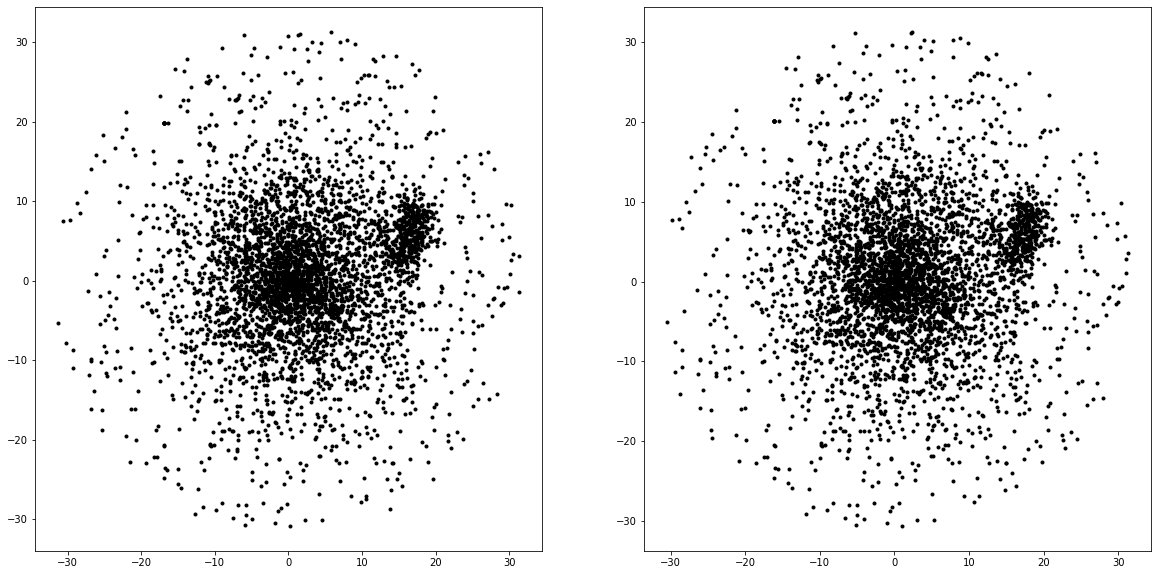

In [336]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
ax[0].plot(deltas0[:, 0], deltas0[:, 1], "k.")
ax[1].plot(deltas[:, 0], deltas[:, 1], "k.")
plt.show()

array([0.32979713, 0.11724335])